# 01. Data Exploration

## Objective
Load the NYC Airbnb dataset using **NumPy exclusively** (assisted by Python's `csv` module for parsing) and perform Exploratory Data Analysis (EDA) to understand the data distribution and relationships.

## 1. Data Loading
We will load the `AB_NYC_2019.csv` file. Since the file contains mixed types and quoted strings with commas, `np.genfromtxt` can be complex to configure directly. We will use Python's built-in `csv` module to parse the rows and then convert them to a structured NumPy array.

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure plots display in the notebook
%matplotlib inline

In [2]:
DATA_PATH = '../data/raw/AB_NYC_2019.csv'

def load_data(file_path):
    with open(file_path, mode='r', encoding='utf-8') as f:
        reader = csv.reader(f)
        header = next(reader)
        data = list(reader)
    
    # Convert to NumPy array of objects to handle mixed types temporarily
    # We will refine types for specific columns later during analysis
    data_np = np.array(data, dtype=object)
    return header, data_np

# Load the data
header, data = load_data(DATA_PATH)

## 2. Data Overview
Displaying the first 5 rows, column names, and data shape.

In [3]:
print("Feature Names (Columns):\n", header)
print("\nData Shape:", data.shape)
print("\nFirst 5 Rows:")
print(data[:5])

Feature Names (Columns):
 ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

Data Shape: (48895, 16)

First 5 Rows:
[['2539' 'Clean & quiet apt home by the park' '2787' 'John' 'Brooklyn'
  'Kensington' '40.64749' '-73.97237' 'Private room' '149' '1' '9'
  '2018-10-19' '0.21' '6' '365']
 ['2595' 'Skylit Midtown Castle' '2845' 'Jennifer' 'Manhattan' 'Midtown'
  '40.75362' '-73.98377' 'Entire home/apt' '225' '1' '45' '2019-05-21'
  '0.38' '2' '355']
 ['3647' 'THE VILLAGE OF HARLEM....NEW YORK !' '4632' 'Elisabeth'
  'Manhattan' 'Harlem' '40.80902' '-73.9419' 'Private room' '150' '3' '0'
  '' '' '1' '365']
 ['3831' 'Cozy Entire Floor of Brownstone' '4869' 'LisaRoxanne'
  'Brooklyn' 'Clinton Hill' '40.68514' '-73.95976' 'Entire home/apt' '89'
  '1' '270' '2019-07-05' '4.64' '1' '194']
 ['5

Type

In [4]:
header = data[0]
data = data[1:]
for e in data[1]:
    print("Type of ", type(e))
    print("Value ", e)

Type of  <class 'str'>
Value  3647
Type of  <class 'str'>
Value  THE VILLAGE OF HARLEM....NEW YORK !
Type of  <class 'str'>
Value  4632
Type of  <class 'str'>
Value  Elisabeth
Type of  <class 'str'>
Value  Manhattan
Type of  <class 'str'>
Value  Harlem
Type of  <class 'str'>
Value  40.80902
Type of  <class 'str'>
Value  -73.9419
Type of  <class 'str'>
Value  Private room
Type of  <class 'str'>
Value  150
Type of  <class 'str'>
Value  3
Type of  <class 'str'>
Value  0
Type of  <class 'str'>
Value  
Type of  <class 'str'>
Value  
Type of  <class 'str'>
Value  1
Type of  <class 'str'>
Value  365


### Data Cleaning and Conversion

Define a structured NumPy data type to handle mixed types (int, float, datetime, string). We also clean missing values (empty strings) before conversion. This conversion is necessary to facilitate meaningful statistical calculations and visualization, which is not possible with raw string data

In [5]:
# Define the specific data type for each field
# Using native types (int64, float64, datetime) enables vectorization
dtype = np.dtype([
    ('id', np.int64),
    ('name', 'U100'),
    ('host_id', np.int64),
    ('host_name', 'U50'),
    ('neighbourhood_group', 'U50'),
    ('neighbourhood', 'U50'),
    ('latitude', np.float64),
    ('longitude', np.float64),
    ('room_type', 'U20'),
    ('price', np.int32),
    ('minimum_nights', np.int32),
    ('number_of_reviews', np.int32),
    ('last_review', 'M8[D]'),           # NumPy datetime format
    ('reviews_per_month', np.float64),
    ('calculated_host_listings_count', np.int32),
    ('availability_365', np.int32)
])

# Helpers for vectorized cleaning of empty strings
def clean_int(arr):
    # Replace empty strings with 0 before converting
    return np.where(arr == '', '0', arr).astype(np.int32)

def clean_float(arr):
    # Replace empty strings with nan before converting
    return np.where(arr == '', 'nan', arr).astype(np.float64)

def clean_date(arr):
    # Replace empty strings with NaT (Not a Time) before converting
    return np.where(arr == '', 'NaT', arr).astype('M8[D]')

# Create a new empty structured array
N = len(data)
structured_data = np.zeros(N, dtype=dtype)

# Assign columns using vectorized conversion
# data[:, i] extracts the column from the raw string array
structured_data['id'] = data[:, 0].astype(np.int64)
structured_data['name'] = data[:, 1]
structured_data['host_id'] = data[:, 2].astype(np.int64)
structured_data['host_name'] = data[:, 3]
structured_data['neighbourhood_group'] = data[:, 4]
structured_data['neighbourhood'] = data[:, 5]
structured_data['latitude'] = clean_float(data[:, 6])
structured_data['longitude'] = clean_float(data[:, 7])
structured_data['room_type'] = data[:, 8]
structured_data['price'] = clean_int(data[:, 9])
structured_data['minimum_nights'] = clean_int(data[:, 10])
structured_data['number_of_reviews'] = clean_int(data[:, 11])
structured_data['last_review'] = clean_date(data[:, 12])
structured_data['reviews_per_month'] = clean_float(data[:, 13])
structured_data['calculated_host_listings_count'] = clean_int(data[:, 14])
structured_data['availability_365'] = clean_int(data[:, 15])

data = structured_data
print("New Data Shape:", data.shape)
print("Dtype Names:", data.dtype.names)
print("\nFirst 3 rows (structured):")
print(data[:3])

New Data Shape: (48894,)
Dtype Names: ('id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365')

First 3 rows (structured):
[(2595, 'Skylit Midtown Castle', 2845, 'Jennifer', 'Manhattan', 'Midtown', 40.75362, -73.98377, 'Entire home/apt', 225, 1,  45, '2019-05-21', 0.38, 2, 355)
 (3647, 'THE VILLAGE OF HARLEM....NEW YORK !', 4632, 'Elisabeth', 'Manhattan', 'Harlem', 40.80902, -73.9419 , 'Private room', 150, 3,   0,        'NaT',  nan, 1, 365)
 (3831, 'Cozy Entire Floor of Brownstone', 4869, 'LisaRoxanne', 'Brooklyn', 'Clinton Hill', 40.68514, -73.95976, 'Entire home/apt',  89, 1, 270, '2019-07-05', 4.64, 1, 194)]


### Verifying Data Types

Checking the data types of the structured array to ensure meaningful types (int, float,...) instead of generic strings

In [6]:
header = data[0]
for e in data[1]:
    print("Type of ", type(e))
    print("Value ", e)

Type of  <class 'numpy.int64'>
Value  3647
Type of  <class 'numpy.str_'>
Value  THE VILLAGE OF HARLEM....NEW YORK !
Type of  <class 'numpy.int64'>
Value  4632
Type of  <class 'numpy.str_'>
Value  Elisabeth
Type of  <class 'numpy.str_'>
Value  Manhattan
Type of  <class 'numpy.str_'>
Value  Harlem
Type of  <class 'numpy.float64'>
Value  40.80902
Type of  <class 'numpy.float64'>
Value  -73.9419
Type of  <class 'numpy.str_'>
Value  Private room
Type of  <class 'numpy.int32'>
Value  150
Type of  <class 'numpy.int32'>
Value  3
Type of  <class 'numpy.int32'>
Value  0
Type of  <class 'numpy.datetime64'>
Value  NaT
Type of  <class 'numpy.float64'>
Value  nan
Type of  <class 'numpy.int32'>
Value  1
Type of  <class 'numpy.int32'>
Value  365


## 3. Exploratory Data Analysis (EDA)

### 3.1. Price Distribution by Borough
**Question**: What is the average listing price across the 5 main boroughs (`neighbourhood_group`)?

Average Price by Borough:
Bronx: $87.50
Brooklyn: $124.38
Manhattan: $196.88
Queens: $99.52
Staten Island: $114.81


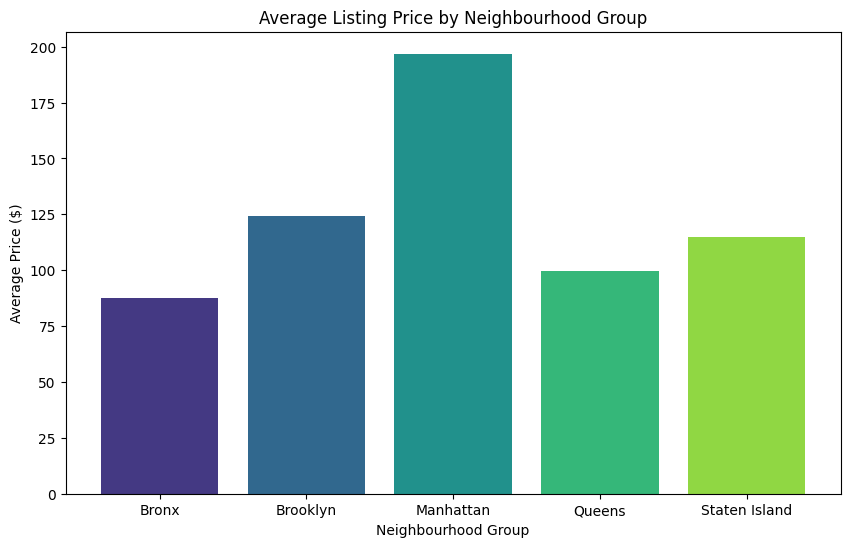

In [7]:
neighbourhood_groups = data['neighbourhood_group']
prices = data['price']  

# grouping
unique_boroughs, borough_indices = np.unique(neighbourhood_groups, return_inverse=True)

# sum and count
price_sums = np.bincount(borough_indices, weights=prices)
counts = np.bincount(borough_indices)

# mean 
mean_prices = price_sums / counts

print("Average Price by Borough:")
for borough, price in zip(unique_boroughs, mean_prices):
    print(f"{borough}: ${price:.2f}")


plt.figure(figsize=(10, 6))
colors = sns.color_palette('viridis', len(unique_boroughs))
plt.bar(unique_boroughs, mean_prices, color=colors)
plt.title('Average Listing Price by Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Average Price ($)')
plt.show()

### Observation: Price by Borough

Manhattan has the highest average listing price ($196.88), which is expected as it is the most central and popular borough. Brooklyn follows at $124.38. The Bronx, Queens, and Staten Island offer significantly more affordable options, averaging under $115 per night.

### 3.2. Room Type Market Share
**Question**: What is the proportion of each `room_type`?

Room Type Distribution:
Entire home/apt: 25409 (51.97%)
Private room: 22325 (45.66%)
Shared room: 1160 (2.37%)


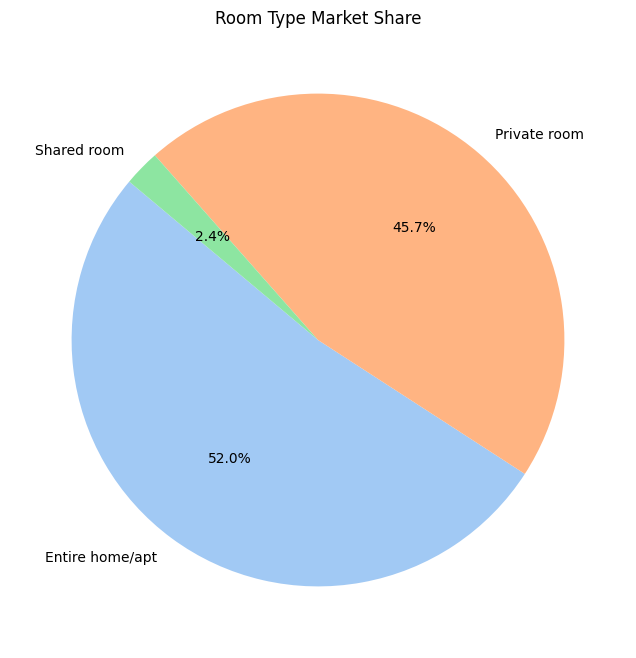

In [8]:
room_types = data['room_type']

# counts
unique_room_types, counts = np.unique(room_types, return_counts=True)

# percentages
total_listings = len(room_types)
percentages = (counts / total_listings) * 100

print("Room Type Distribution:")
for rt, count, pct in zip(unique_room_types, counts, percentages):
    print(f"{rt}: {count} ({pct:.2f}%)")

# pie Chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=unique_room_types, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Room Type Market Share')
plt.show()

### Observation:

"Entire home/apt" and "Private room" are the dominant room types, together accounting for over 97% of all listings. "Shared room" listings are very rare (only ~2.4%), indicating that most guests prefer some level of privacy.

### 3.3. Activity vs. Price
**Question**: Is there a correlation between `price` and the listing's popularity (`number_of_reviews`)?

Correlation between Price and Number of Reviews: -0.0480


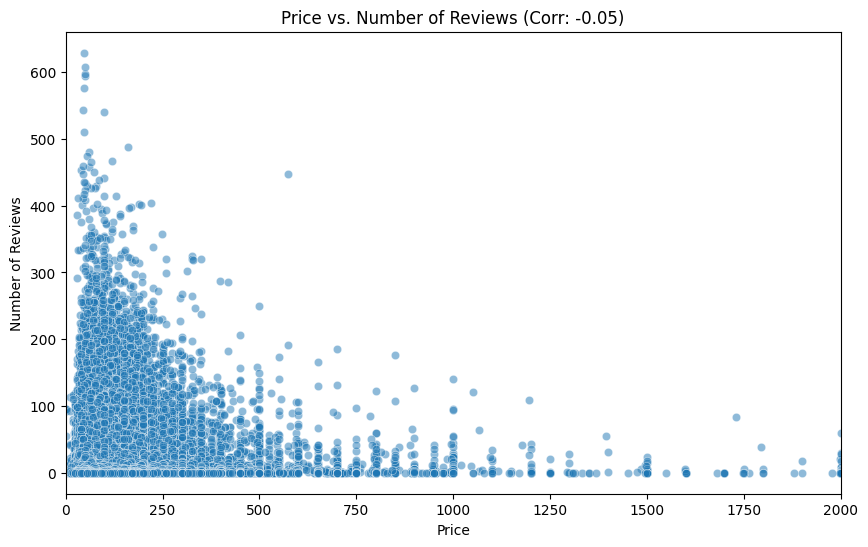

In [9]:
num_reviews_str = data['number_of_reviews']
num_reviews = num_reviews_str.astype(float)

# calculate Correlation
correlation = np.corrcoef(prices, num_reviews)[0, 1]
print(f"Correlation between Price and Number of Reviews: {correlation:.4f}")

# scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=prices, y=num_reviews, alpha=0.5)
plt.title(f'Price vs. Number of Reviews (Corr: {correlation:.2f})')
plt.xlabel('Price')
plt.ylabel('Number of Reviews')
plt.xlim(0, 2000) # Limiting x-axis to see the dense part better
plt.show()

### Observation: Correlation Analysis

The correlation coefficient between Price and Number of Reviews is approximately **-0.05**. This is a very weak negative correlation, suggesting that **price is not a strong predictor of a listing's popularity** (in terms of reviews). Cheaper listings don't necessarily get more reviews, and expensive ones aren't necessarily ignored.

### 3.4. Busiest Hosts
**Question**: Identify the **Top 10 Host IDs** by the number of active listings (`calculated_host_listings_count`).

Top 10 Busiest Hosts:
Host ID: 219517861, Listings: 327
Host ID: 107434423, Listings: 232
Host ID: 30283594, Listings: 121
Host ID: 137358866, Listings: 103
Host ID: 16098958, Listings: 96
Host ID: 12243051, Listings: 96
Host ID: 61391963, Listings: 91
Host ID: 22541573, Listings: 87
Host ID: 200380610, Listings: 65
Host ID: 7503643, Listings: 52


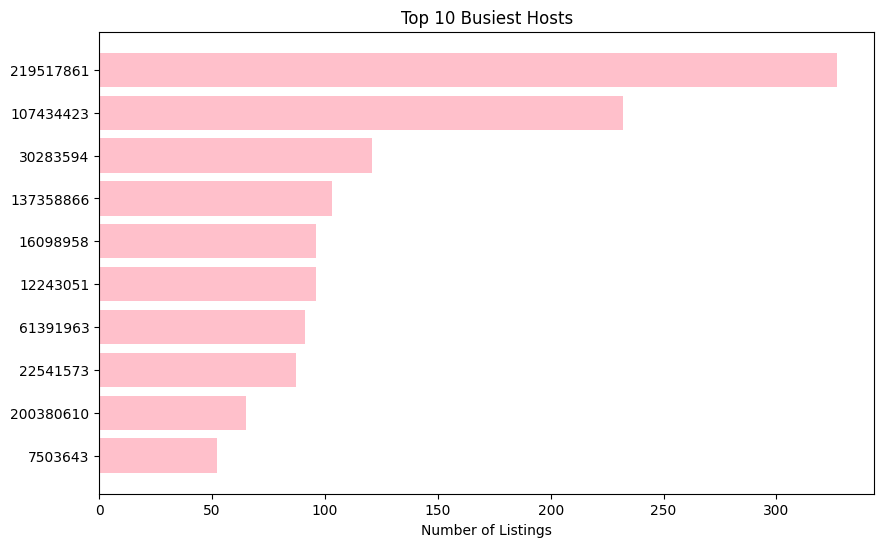

In [10]:
host_ids = data['host_id']
host_counts_str = data['calculated_host_listings_count']
host_counts = host_counts_str.astype(int)

unique_hosts, real_counts = np.unique(host_ids, return_counts=True)

# Sort by real_counts descending
sorted_params = np.argsort(real_counts)[::-1]
top_10_indices = sorted_params[:10]

top_10_hosts = unique_hosts[top_10_indices]
top_10_counts = real_counts[top_10_indices]

print("Top 10 Busiest Hosts:")
for host, count in zip(top_10_hosts, top_10_counts):
    print(f"Host ID: {host}, Listings: {count}")

# Visualization: Horizontal Bar Chart
plt.figure(figsize=(10, 6))
y_pos = np.arange(len(top_10_hosts))
plt.barh(y_pos, top_10_counts, align='center', color='pink')
plt.yticks(y_pos, top_10_hosts)
plt.gca().invert_yaxis()  
plt.xlabel('Number of Listings')
plt.title('Top 10 Busiest Hosts')
plt.show()

### 3.5 Find out more about neiberhoods presented 

In [11]:
nei_list = ['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx']
stats_list = ['min', '25%', '50%', '75%', 'max']
PERCENTILES = [0, 25, 50, 75, 100] 

stat_array = np.empty((len(nei_list), len(stats_list)))

for i, borough in enumerate(nei_list):
    mask = (neighbourhood_groups == borough)
    borough_prices = prices[mask]
    
    if borough_prices.size > 0:

        stats = np.percentile(borough_prices, PERCENTILES)
        stat_array[i] = stats
    else:
        stat_array[i] = np.full(len(stats_list), np.nan)

print("{:<15} {:<8} {:<8} {:<8} {:<8} {:<8}".format("Borough", *stats_list))
print("-" * 55)
for i, borough in enumerate(nei_list):
    print("{:<15} {:<8.2f} {:<8.2f} {:<8.2f} {:<8.2f} {:<8.2f}".format(
        borough, *stat_array[i]
    ))


Borough         min      25%      50%      75%      max     
-------------------------------------------------------
Brooklyn        0.00     60.00    90.00    150.00   10000.00
Manhattan       0.00     95.00    150.00   220.00   10000.00
Queens          10.00    50.00    75.00    110.00   10000.00
Staten Island   13.00    50.00    75.00    110.00   5000.00 
Bronx           0.00     45.00    65.00    99.00    2500.00 


We can see from our statistical table that we have some extreme values, therefore we need to remove them for the sake of a better visualization


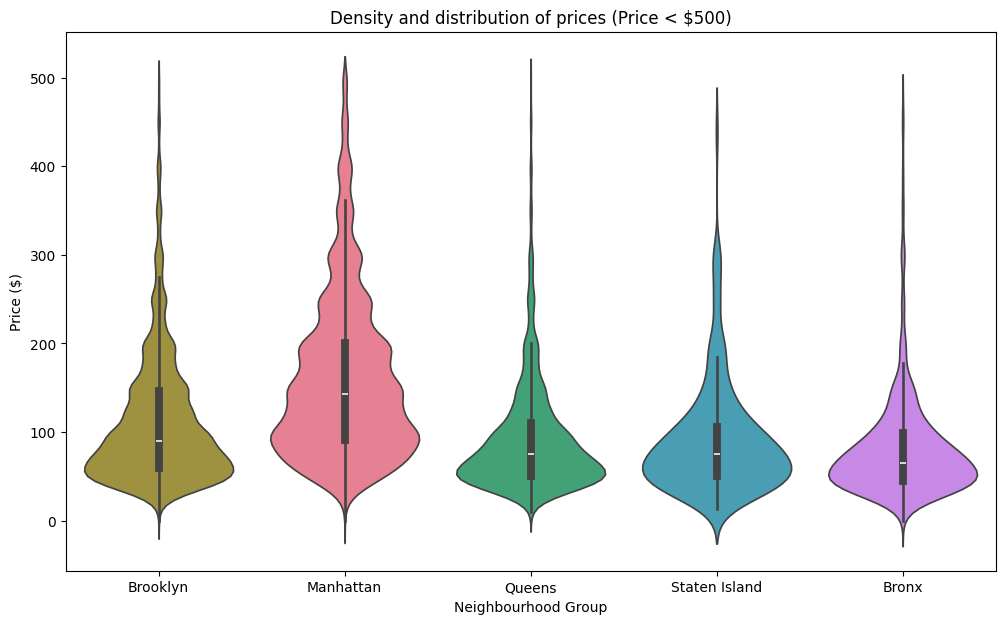

In [12]:
mask = data['price'] < 500
nei_gr_filtered = data['neighbourhood_group'][mask]
price_filtered = data['price'][mask]

plt.figure(figsize=(12, 7))
viz_2 = sns.violinplot(
    x=nei_gr_filtered, 
    y=price_filtered, 
    order=nei_list,
    palette='husl',
    hue=nei_gr_filtered
)
viz_2.set_title(f'Density and distribution of prices (Price < $500)')
viz_2.set_xlabel('Neighbourhood Group')
viz_2.set_ylabel('Price ($)')
plt.show()


The statistical table and violin plot clearly reveal the expected pricing hierarchy among NYC boroughs:

- Manhattan holds the highest average price (around $150) and exhibits the widest distribution of listing prices.

- Brooklyn follows, maintaining the second-highest average (around $90).

- Queens and Staten Island demonstrate the most similar and stable price distributions.

- The Bronx consistently offers the cheapest average rate among the five boroughs.

This density and price order are consistent with the boroughs' established cost of living, where Manhattan is known globally as a premium location, driving its listings to the top of the price range.

Top 10 Neighbourhoods:
Williamsburg: 3920
Bedford-Stuyvesant: 3714
Harlem: 2658
Bushwick: 2465
Upper West Side: 1971
Hell's Kitchen: 1958
East Village: 1853
Upper East Side: 1798
Crown Heights: 1564
Midtown: 1545


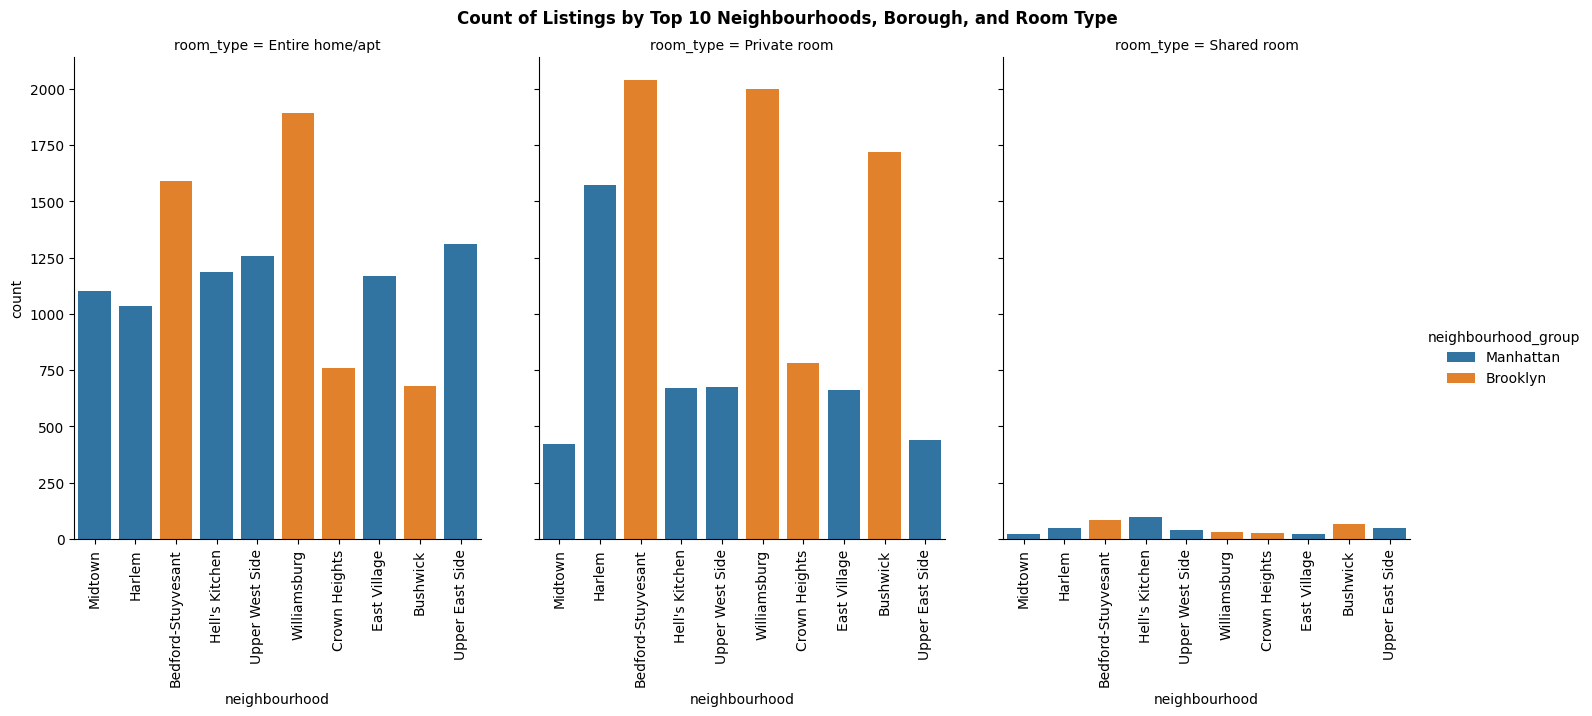

In [13]:
neighbourhood = data['neighbourhood']
neighbourhood_groups = data['neighbourhood_group']
room_type = data['room_type']

unique_neigh, counts = np.unique(neighbourhood, return_counts=True)

sorted_indices = np.argsort(counts)[::-1]

top_10_neighbourhoods = unique_neigh[sorted_indices][:10]

print("Top 10 Neighbourhoods:")
for i, n in enumerate(top_10_neighbourhoods):
    print(f"{n}: {counts[sorted_indices][i]}")

mask_top_10 = np.zeros(neighbourhood.shape, dtype=bool)

for n in top_10_neighbourhoods:
    mask_top_10 = mask_top_10 | (data['neighbourhood'] == n)

sub_neighbourhood = neighbourhood[mask_top_10]
sub_neighbourhood_group = neighbourhood_groups[mask_top_10]
sub_room_type = room_type[mask_top_10]

viz_data = {
    'neighbourhood': sub_neighbourhood,
    'neighbourhood_group': sub_neighbourhood_group,
    'room_type': sub_room_type
}

viz_3 = sns.catplot(
    data=viz_data, 
    x='neighbourhood', 
    hue='neighbourhood_group', 
    col='room_type', 
    kind='count',
    height=6, 
    aspect=0.8
)
viz_3.set_xticklabels(rotation=90)
plt.subplots_adjust(top=0.9)
viz_3.fig.suptitle('Count of Listings by Top 10 Neighbourhoods, Borough, and Room Type', weight='bold')
plt.show()


1.  **Shared Room Scarcity**: The most striking observation is that the number of **"Shared room"** type Airbnb listings is **negligible** or **almost entirely absent** within these 10 most listing-populated neighborhoods.
2.  **Borough Dominance**: The top 10 busiest neighborhoods are represented exclusively by just two boroughs: **Manhattan** and **Brooklyn**. This strongly validates the assumption that these are the two primary destinations for short-term rentals in NYC.
3.  **Leading Neighbourhoods**:
    * In **Brooklyn**, **Williamsburg** and **Bedford-Stuyvesant** show the highest counts across the relevant room types.
    * In **Manhattan**, **Harlem** stands out as having a significant number of listings among the top group.

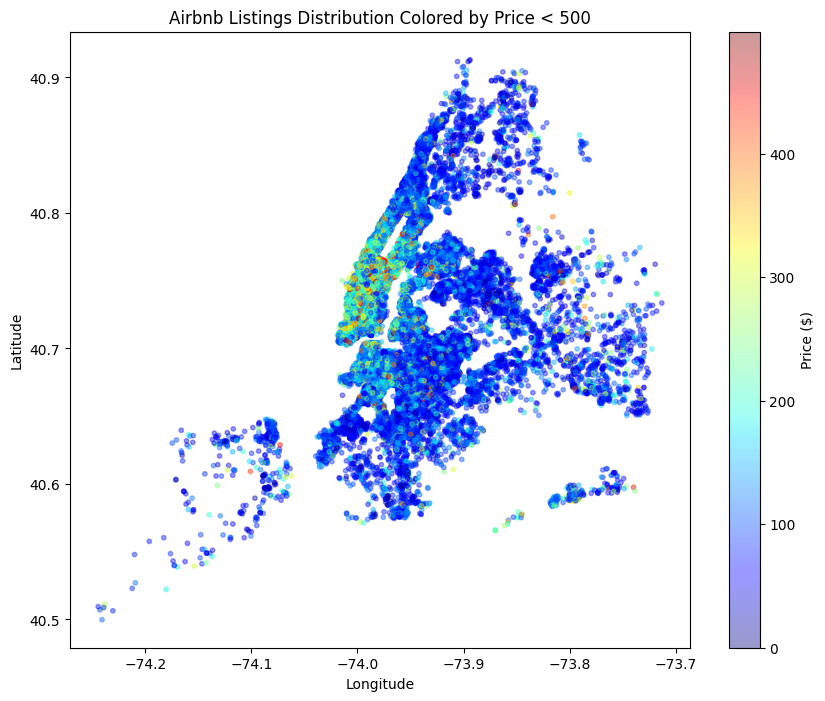

In [14]:
mask_no_extreme = (prices < 500) 

longitude_filtered = data['longitude'][mask_no_extreme]
latitude_filtered = data['latitude'][mask_no_extreme]
price_filtered = data['price'][mask_no_extreme]

plt.figure(figsize=(10, 8))

scatter = plt.scatter(
    x=longitude_filtered, 
    y=latitude_filtered, 
    c=price_filtered,  
    cmap=plt.get_cmap('jet'), 
    s=10, 
    alpha=0.4
)

plt.title('Airbnb Listings Distribution Colored by Price < 500')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

cbar = plt.colorbar(scatter)
cbar.set_label('Price ($)')

plt.show()

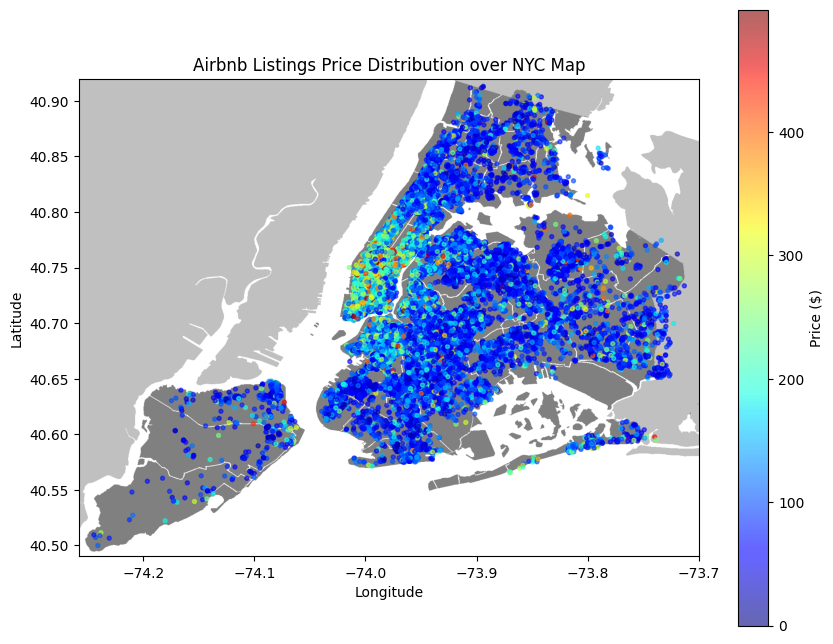

In [15]:
nyc_img = plt.imread('../data/raw/nyc_map.png')

plt.figure(figsize=(10, 8))

plt.imshow(nyc_img, zorder=0, extent=[-74.258, -73.7, 40.49,40.92], aspect='equal')

scatter = plt.scatter(
    x=longitude_filtered, 
    y=latitude_filtered, 
    c=price_filtered, 
    cmap=plt.get_cmap('jet'), 
    s=8,
    alpha=0.6, 
    zorder=1 
)


plt.title('Airbnb Listings Price Distribution over NYC Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

cbar = plt.colorbar(scatter)
cbar.set_label('Price ($)')


### Observation:

- **Density**: Listings are heavily concentrated in Manhattan and the western parts of Brooklyn (Williamsburg, Bed-Stuy). Queens and the Bronx have sparser listings.
- **Price**: The map confirms that the highest-priced listings (indicated by lighter/yellow colors) are clustered in Manhattan and trendier parts of Brooklyn. The outlying boroughs generally have lower-priced listings.

## 4. Statistical Hypothesis Testing
To rigorously validate our EDA observation that "Manhattan is more expensive than Brooklyn", we perform a statistical hypothesis test.

**Objective**: Determine if the difference in average prices between Manhattan and Brooklyn is statistically significant.

We define our hypotheses:
-   **Null Hypothesis ($H_0$)**: The average listing price in Manhattan is equal to that in Brooklyn ($\mu_M = \mu_B$).
-   **Alternative Hypothesis ($H_1$)**: The average listing price in Manhattan is different from that in Brooklyn ($\mu_M \neq \mu_B$).

**Methodology**:
Since the sample sizes are large and variances might be unequal, we use **Welch's t-test**. We calculate the t-statistic manually using NumPy arithmetic operations to minimize error:

$$ t = \frac{\bar{X}_1 - \bar{X}_2}{\sqrt{\frac{s_1^2}{N_1} + \frac{s_2^2}{N_2}}} $$

Where $\bar{X}$ is the mean, $s^2$ is the variance, and $N$ is the sample size.
We reject $H_0$ if $|t| > 1.96$ (corresponding to a 95% confidence interval for large samples).

In [16]:
price_manhattan = data[data['neighbourhood_group'] == 'Manhattan']['price'].astype(float)
price_brooklyn = data[data['neighbourhood_group'] == 'Brooklyn']['price'].astype(float)

n_m = len(price_manhattan)
n_b = len(price_brooklyn)

# Mean
mean_m = np.mean(price_manhattan)
mean_b = np.mean(price_brooklyn)

# Variance
var_m = np.var(price_manhattan, ddof=1)
var_b = np.var(price_brooklyn, ddof=1)

print(f"Manhattan: Mean=${mean_m:.2f}, Var={var_m:.2f}, N={n_m}")
print(f"Brooklyn : Mean=${mean_b:.2f}, Var={var_b:.2f}, N={n_b}")

numerator = mean_m - mean_b
denominator = np.sqrt((var_m / n_m) + (var_b / n_b))

t_stat = numerator / denominator

print("-" * 30)
print(f"T-statistic: {t_stat:.4f}")

CRITICAL_VALUE = 1.96

if abs(t_stat) > CRITICAL_VALUE:
    print("Result: REJECT Null Hypothesis (H0).")
    print("Conclusion: There is a statistically significant difference in prices.")
else:
    print("Result: FAIL to reject Null Hypothesis (H0).")
    print("Conclusion: No statistically significant difference found.")

Manhattan: Mean=$196.88, Var=84904.16, N=21661
Brooklyn : Mean=$124.38, Var=34923.43, N=20103
------------------------------
T-statistic: 30.4798
Result: REJECT Null Hypothesis (H0).
Conclusion: There is a statistically significant difference in prices.


### Test 2: Room Type Price Analysis
**Objective**: Determine if "Entire home/apt" listings are significantly more expensive than "Private room" listings.

-   **Null Hypothesis ($H_0$)**: The average price of Entire homes is equal to Private rooms ($\mu_{Entire} = \mu_{Private}$).
-   **Alternative Hypothesis ($H_1$)**: The average prices are different ($\mu_{Entire} \neq \mu_{Private}$).

We again use Welch's t-test due to potential unequal variances between these two distinct market segments.

In [17]:
# 1. Filter Data
price_entire = data[data['room_type'] == 'Entire home/apt']['price'].astype(float)
price_private = data[data['room_type'] == 'Private room']['price'].astype(float)

# 2. Calculate Stats (Vectorized)
n_e = len(price_entire)
n_p = len(price_private)

mean_e = np.mean(price_entire)
mean_p = np.mean(price_private)

var_e = np.var(price_entire, ddof=1)
var_p = np.var(price_private, ddof=1)

print(f"Entire home: Mean=${mean_e:.2f}, Var={var_e:.2f}, N={n_e}")
print(f"Private rm : Mean=${mean_p:.2f}, Var={var_p:.2f}, N={n_p}")

# 3. Calculate t-statistic
numerator = mean_e - mean_p
denominator = np.sqrt((var_e / n_e) + (var_p / n_p))
t_stat_2 = numerator / denominator

print("-" * 30)
print(f"T-statistic: {t_stat_2:.4f}")

# 4. Conclusion
if abs(t_stat_2) > 1.96: # 95% confidence level
    print("Result: REJECT H0. There is a significant price difference.")
else:
    print("Result: FAIL to reject H0.")

Entire home: Mean=$211.79, Var=80679.64, N=25409
Private rm : Mean=$89.78, Var=25666.72, N=22325
------------------------------
T-statistic: 58.6715
Result: REJECT H0. There is a significant price difference.


### Test 3: Short-term vs. Long-term Rentals
**Objective**: Determine if the minimum stay requirement (`minimum_nights`) influences the listing price.
We categorize listings into two groups based on a typical weekly rental threshold:
-   **Group 1 (Short-term)**: `minimum_nights` < 7 days.
-   **Group 2 (Long-term)**: `minimum_nights` >= 7 days.

-   **Null Hypothesis ($H_0$)**: $\mu_{Short} = \mu_{Long}$
-   **Alternative Hypothesis ($H_1$)**: $\mu_{Short} \neq \mu_{Long}$

In [18]:
# Function for reusable T-test logic
def perform_t_test(group1, group2, label1, label2):
    n1, n2 = len(group1), len(group2)
    m1, m2 = np.mean(group1), np.mean(group2)
    v1, v2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    
    # Welch's t-statistic formula
    t_stat = (m1 - m2) / np.sqrt((v1/n1) + (v2/n2))
    
    print(f"{label1}: Mean=${m1:.2f}, N={n1}")
    print(f"{label2}: Mean=${m2:.2f}, N={n2}")
    print(f"T-statistic: {t_stat:.4f}")
    
    if abs(t_stat) > 1.96:
        print("Result: REJECT H0 (Significant Difference)")
    else:
        print("Result: FAIL to reject H0")

# Execution for Test 3
price_short = data[data['minimum_nights'] < 7]['price'].astype(float)
price_long = data[data['minimum_nights'] >= 7]['price'].astype(float)

perform_t_test(price_short, price_long, "Short-term (< 7 days)", "Long-term (>= 7 days)")

Short-term (< 7 days): Mean=$150.29, N=39503
Long-term (>= 7 days): Mean=$162.95, N=9391
T-statistic: -3.5551
Result: REJECT H0 (Significant Difference)


### Test 4: Impact of Review Volume on Price
**Objective**: Investigate the relationship between a listing's popularity (measured by `number_of_reviews`) and its price.
EDA suggested a negative correlation. We test this by comparing extreme groups:
-   **Group 1 (Low Activity)**: `number_of_reviews` <= 10 reviews.
-   **Group 2 (High Activity)**: `number_of_reviews` > 50 reviews.

-   **Null Hypothesis ($H_0$)**: $\mu_{Low} = \mu_{High}$
-   **Alternative Hypothesis ($H_1$)**: $\mu_{Low} \neq \mu_{High}$

In [19]:
mask_low = data['number_of_reviews'] <= 10
mask_high = data['number_of_reviews'] > 50

price_low_reviews = data[mask_low]['price'].astype(float)
price_high_reviews = data[mask_high]['price'].astype(float)

perform_t_test(price_low_reviews, price_high_reviews, "Low Reviews (<=10)", "High Reviews (>50)")

Low Reviews (<=10): Mean=$163.44, N=30322
High Reviews (>50): Mean=$128.71, N=6959
T-statistic: 16.8378
Result: REJECT H0 (Significant Difference)
